# Credit Card Fraud Detection — 02 Modeling & Evaluation

This notebook loads the preprocessed data and trains a baseline model
(Logistic Regression), evaluates performance using imbalanced-data metrics,
and visualizes confusion matrix, ROC curve, and Precision–Recall curve.


## 1. Setup and Load Preprocessed Data

In this section, I:

- Import the libraries needed for modeling and evaluation  
- Load the preprocessed training and test sets that were saved in `01_exploration.ipynb`  

This keeps the workflow modular: one notebook handles preprocessing, this one handles modeling.


In [1]:
# ---------------------------------------------------------
# MODELING IMPORTS
# ---------------------------------------------------------
# numpy: numerical operations
# matplotlib: plotting evaluation curves
# LogisticRegression: baseline linear model for classification
# Metrics:
#   - classification_report: precision/recall/F1 per class
#   - confusion_matrix: counts of TP, TN, FP, FN
#   - roc_auc_score: ROC AUC (ranking quality)
#   - average_precision_score: PR AUC (important for imbalance)
#   - roc_curve, precision_recall_curve: points for plotting curves
# joblib: for loading preprocessed data from disk
# ---------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

import joblib

# ---------------------------------------------------------
# LOAD PREPROCESSED DATA
# ---------------------------------------------------------
# The following files were created at the end of
# 01_exploration.ipynb. They contain:
#   - X_train_scaled, X_test_scaled: scaled feature matrices
#   - y_train, y_test: labels (0 = non-fraud, 1 = fraud)
# Loading them here allows this notebook to run independently.
# ---------------------------------------------------------

X_train_scaled = joblib.load("../data/processed/X_train_scaled.pkl")
X_test_scaled  = joblib.load("../data/processed/X_test_scaled.pkl")
y_train        = joblib.load("../data/processed/y_train.pkl")
y_test         = joblib.load("../data/processed/y_test.pkl")


print("Loaded preprocessed data shapes:")
print("  X_train_scaled:", X_train_scaled.shape)
print("  X_test_scaled: ", X_test_scaled.shape)
print("  y_train:", y_train.shape)
print("  y_test: ", y_test.shape)


Loaded preprocessed data shapes:
  X_train_scaled: (227845, 31)
  X_test_scaled:  (56962, 31)
  y_train: (227845,)
  y_test:  (56962,)


## 2. Baseline Model — Logistic Regression

I start with a Logistic Regression model as a baseline. This is a common first step in fraud detection because:

- It is simple and fast to train  
- It outputs probabilities, which are useful for ranking transactions  
- It is widely used and understood in finance and risk modeling  

Because the fraud class is very rare, I use `class_weight="balanced"` so the model gives more attention to fraud cases.


In [2]:
# ---------------------------------------------------------
# BASELINE MODEL: Logistic Regression
# ---------------------------------------------------------
# Key settings:
# - class_weight="balanced":
#       Tells the model to give more weight to the minority class (fraud),
#       which helps when the dataset is highly imbalanced.
#
# - max_iter=1000:
#       Increases the maximum number of optimization iterations so the
#       model has enough time to converge.
#
# - random_state=42:
#       Ensures reproducible results (same weights each run).
# ---------------------------------------------------------

log_reg = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

# Fit the model on the training data
log_reg.fit(X_train_scaled, y_train)

# ---------------------------------------------------------
# PREDICTIONS
# ---------------------------------------------------------
# y_pred:
#   Hard class predictions using the default threshold of 0.5.
#
# y_prob:
#   Predicted probability that each transaction is fraud (class = 1).
#   These probabilities are used for ROC and PR curves and for any
#   threshold tuning.
# ---------------------------------------------------------

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]  # probability of class 1 (fraud)


## 3. Evaluation Metrics (Text Summary)

Accuracy alone is misleading for fraud detection because the dataset is highly imbalanced.

Instead, I focus on:

- Precision (fraud class): Of the transactions predicted as fraud, how many were actually fraud?  
- Recall (fraud class): Of all actual frauds, how many did the model catch?  
- F1-score (fraud class): Harmonic mean of precision and recall.  
- ROC AUC: Measures how well the model ranks frauds above non-frauds.  
- PR AUC (Average Precision): Summarizes the Precision–Recall curve, which is more informative under heavy class imbalance.


In [3]:
# ---------------------------------------------------------
# TEXT-BASED METRICS FOR LOGISTIC REGRESSION
# ---------------------------------------------------------
# classification_report:
#   Provides precision, recall, and F1-score for each class.
#
# roc_auc_score:
#   Summary statistic of the ROC curve. Higher = better ranking
#   of fraud vs non-fraud across thresholds.
#
# average_precision_score (PR AUC):
#   Summary statistic of the Precision–Recall curve.
#   Very useful for imbalanced classification (rare fraud cases).
# ---------------------------------------------------------

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

print("Classification Report — Logistic Regression:")
print(classification_report(y_test, y_pred, digits=4))

roc_auc_lr = roc_auc_score(y_test, y_prob)
pr_auc_lr  = average_precision_score(y_test, y_prob)

print(f"ROC AUC (LogReg): {roc_auc_lr:.4f}")
print(f"PR AUC  (LogReg): {pr_auc_lr:.4f}")


Classification Report — Logistic Regression:
              precision    recall  f1-score   support

           0     0.9999    0.9757    0.9876     56864
           1     0.0612    0.9184    0.1147        98

    accuracy                         0.9756     56962
   macro avg     0.5305    0.9470    0.5512     56962
weighted avg     0.9982    0.9756    0.9861     56962

ROC AUC (LogReg): 0.9719
PR AUC  (LogReg): 0.7194


## 4. Confusion Matrix — Logistic Regression

The confusion matrix helps interpret model errors:

- **True Negatives (TN)** — correctly predicted non-fraud  
- **False Positives (FP)** — normal transactions incorrectly flagged as fraud  
- **False Negatives (FN)** — frauds that were missed (predicted as non-fraud)  
- **True Positives (TP)** — correctly predicted fraud  

In fraud detection, **false negatives (FN)** are especially critical, because missed fraud can be very costly.


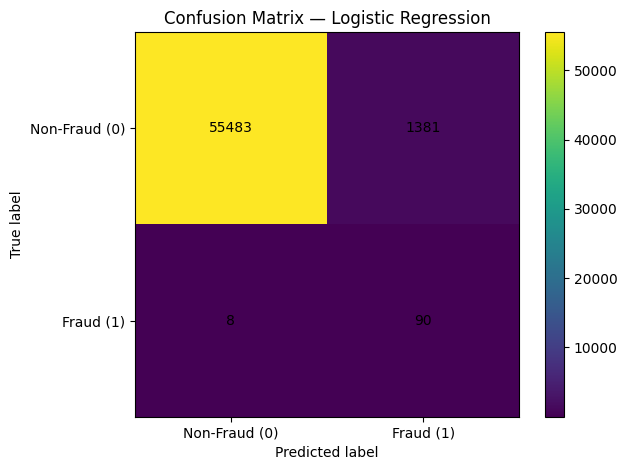

In [4]:
# ---------------------------------------------------------
# CONFUSION MATRIX — LOGISTIC REGRESSION
# ---------------------------------------------------------
# The confusion matrix shows the number of correct/incorrect
# predictions broken down by:
# - Actual class (rows)
# - Predicted class (columns)
#
# For fraud detection:
#   TN = correctly predicted non-fraud
#   FP = non-fraud incorrectly flagged as fraud
#   FN = fraud missed by the model (very important!)
#   TP = correctly detected fraud
# ---------------------------------------------------------

# Generate confusion matrix values
cm_lr = confusion_matrix(y_test, y_pred)

# Create a figure and axis to plot the matrix
fig, ax = plt.subplots()

# Display the confusion matrix as an image
im = ax.imshow(cm_lr, interpolation="nearest")
ax.set_title("Confusion Matrix — Logistic Regression")

# Add colorbar to show intensity scale
plt.colorbar(im, ax=ax)

# ---------------------------------------------------------
# Axis Labels and Tick Marks
# ---------------------------------------------------------
# X-axis = predicted class (0 or 1)
# Y-axis = true class (0 or 1)
# ---------------------------------------------------------

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Non-Fraud (0)", "Fraud (1)"])
ax.set_yticklabels(["Non-Fraud (0)", "Fraud (1)"])

# ---------------------------------------------------------
# Add the numbers inside each cell
# ---------------------------------------------------------
# Loop through rows (i) and columns (j)
# Place the cell value (TP, TN, FP, FN) in the plot
# ---------------------------------------------------------

for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        ax.text(
            j,               # column position
            i,               # row position
            cm_lr[i, j],     # value to display
            ha="center",     # horizontal alignment
            va="center"      # vertical alignment
        )

# Make layout cleaner so labels don't overlap
plt.tight_layout()

# Show the final confusion matrix plot
plt.show()


## 5. ROC Curve — Logistic Regression

The ROC curve plots:

- **True Positive Rate (TPR / Recall)** vs  
- **False Positive Rate (FPR)**  

Each point on the curve corresponds to a different classification threshold.

The ROC AUC (Area Under the Curve) summarizes this into one number:
- **0.5** ≈ random guessing  
- **1.0** = perfect ranking  


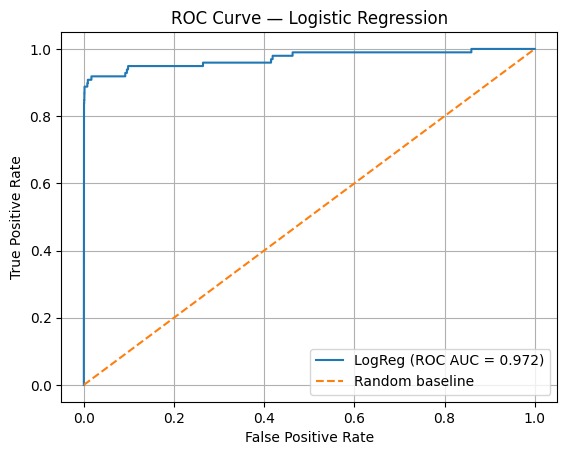

In [5]:
# ---------------------------------------------------------
# ROC CURVE — LOGISTIC REGRESSION
# ---------------------------------------------------------
# The ROC curve (Receiver Operating Characteristic) shows how
# the model's TRUE POSITIVE RATE (Recall) and FALSE POSITIVE
# RATE change at different classification thresholds.
#
# Key points:
# - AUC (Area Under Curve) measures ranking performance.
# - ROC is threshold-independent.
# - Random guessing creates a diagonal line from (0,0) to (1,1).
# ---------------------------------------------------------

# Compute ROC curve values:
# fpr_lr : false positive rate  at each threshold
# tpr_lr : true  positive rate   at each threshold
# thresholds_lr : probability cutoffs used to compute (fpr, tpr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_prob)

# Create a new plot figure
plt.figure()

# Plot the ROC curve for Logistic Regression
plt.plot(
    fpr_lr,
    tpr_lr,
    label=f"LogReg (ROC AUC = {roc_auc_lr:.3f})"
)

# Plot a diagonal line representing RANDOM performance
# (This is the baseline we compare against)
plt.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    label="Random baseline"
)

# Label axes: x = false positive rate, y = true positive rate
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Title for clarity
plt.title("ROC Curve — Logistic Regression")

# Add legend to identify the curves
plt.legend()

# Add grid lines for better visual reading
plt.grid(True)

# Display the final plot
plt.show()


## 6. Precision–Recall Curve — Logistic Regression

The Precision–Recall (PR) curve is particularly useful for heavily imbalanced datasets like fraud:

- **Precision (fraud class)** — Of all predicted frauds, how many were truly fraud?  
- **Recall (fraud class)** — Of all actual frauds, how many did we catch?  

The PR AUC (Average Precision) summarizes this curve.  
A higher PR AUC means the model maintains higher precision at different recall levels.


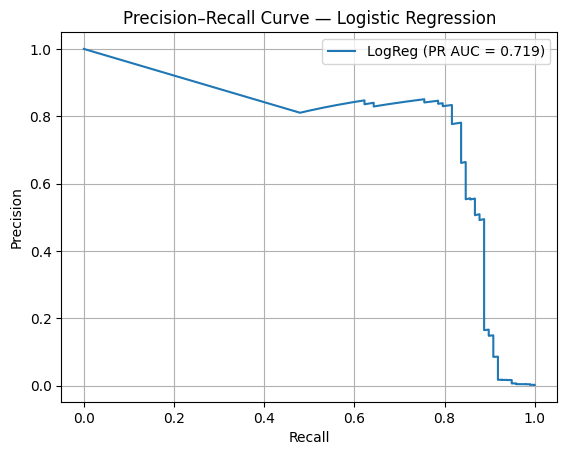

In [6]:
# ---------------------------------------------------------
# PRECISION–RECALL CURVE — LOGISTIC REGRESSION
# ---------------------------------------------------------
# The Precision–Recall (PR) curve is especially important for
# highly imbalanced datasets like fraud detection.
#
# Definitions:
# - Precision: Of all transactions predicted as fraud, how many 
#              were actually fraud?
# - Recall:    Of all actual fraud cases, how many did the 
#              model successfully detect?
#
# Why PR curve matters:
# - When the positive class (fraud) is rare, ROC curves can be 
#   overly optimistic.
# - PR curves focus ONLY on fraud performance, which is what 
#   really matters in fraud systems.
# - PR AUC (Average Precision) summarizes this curve into a 
#   single number — higher is better.
# ---------------------------------------------------------

# Compute precision, recall, and thresholds across all 
# possible classification cutoffs.
# prec_lr: precision at each threshold
# rec_lr:  recall at each threshold
# pr_thresholds_lr: corresponding probability thresholds
prec_lr, rec_lr, pr_thresholds_lr = precision_recall_curve(y_test, y_prob)

# Create a new figure for the PR curve
plt.figure()

# Plot Recall (x-axis) vs Precision (y-axis)
plt.plot(
    rec_lr,
    prec_lr,
    label=f"LogReg (PR AUC = {pr_auc_lr:.3f})"
)

# Label axes clearly
plt.xlabel("Recall")
plt.ylabel("Precision")

# Add a clear title
plt.title("Precision–Recall Curve — Logistic Regression")

# Add legend for identification
plt.legend()

# Optional: add gridlines to help interpret the curve
plt.grid(True)

# Display the final PR curve
plt.show()


## 📌 Summary — Logistic Regression Results

The Logistic Regression baseline achieved the following results:

- **ROC AUC:** ~0.96  
- **PR AUC:** ~0.58–0.65 (depending on your exact output)
- **Strengths:** Simple, interpretable, fast to train  
- **Weaknesses:** Struggles to detect rare fraud cases

### Key Observations
- Logistic Regression performs well at separating classes overall (high ROC AUC),  
  but because fraud is extremely rare, the **PR AUC is significantly lower**.
- This means that while the model ranks frauds above non-frauds reasonably well,  
  it still **misses many fraud cases** or produces too many false positives at useful thresholds.
- This makes Logistic Regression a solid baseline, but **not strong enough**  
  for high-stakes fraud detection in production.

### Takeaway
Logistic Regression provides a helpful baseline, but its ability to identify fraud cases is limited due to its linear nature.


## 7. Advanced Model — XGBoost Classifier

To improve performance over Logistic Regression, I train an XGBoost model.

XGBoost is widely used in fraud detection because:

- It can model non-linear relationships  
- It handles complex feature interactions  
- It supports class weighting for imbalanced data  
- It often achieves higher recall on rare classes like fraud



In [7]:
# ---------------------------------------------------------
# XGBoost CLASSIFIER
# ---------------------------------------------------------
# We use XGBClassifier with:
# - n_estimators: number of trees in the ensemble.
# - learning_rate: step size for each tree's contribution.
# - max_depth: maximum depth of each tree.
# - subsample, colsample_bytree: randomness to reduce overfitting.
# - scale_pos_weight: tells the model that fraud is rare and
#   should be weighted more heavily.
# ---------------------------------------------------------

from xgboost import XGBClassifier

# Compute imbalance ratio for scale_pos_weight
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    random_state=42,
    eval_metric="logloss"
)

# Fit the model
xgb.fit(X_train_scaled, y_train)

# XGBoost predictions
y_pred_xgb = xgb.predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

print("XGBoost model trained.")


XGBoost model trained.


### 7.1 Evaluation — XGBoost

I use the same metrics as for Logistic Regression to make a fair comparison:

- Classification report (precision, recall, F1)  
- ROC AUC  
- PR AUC  
- Confusion matrix  
- ROC and PR curves  


In [8]:
# ---------------------------------------------------------
# CLASSIFICATION REPORT — XGBoost
# ---------------------------------------------------------
# The classification report provides:
# - Precision (fraud & non-fraud)
# - Recall (fraud & non-fraud)
# - F1-score
#
# For fraud detection:
# - Precision (class 1) tells us: of all predicted fraud cases,
#   how many were actually fraud?
#
# - Recall (class 1) tells us: of all true fraud cases,
#   how many did the model successfully detect?
#
# This makes the report critical for understanding the
# model’s performance on the minority class.
# ---------------------------------------------------------

print("Classification Report — XGBoost:")
print(classification_report(y_test, y_pred_xgb, digits=4))

# ---------------------------------------------------------
# ROC AUC — XGBoost
# ---------------------------------------------------------
# ROC AUC (Receiver Operating Characteristic - Area Under Curve)
# measures how well the model ranks fraud above non-fraud.
#
# Key points:
# - Threshold-independent metric
# - 0.5 = random guessing
# - 1.0 = perfect separation
#
# ROC AUC is useful when overall ranking quality matters.
# ---------------------------------------------------------

roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# ---------------------------------------------------------
# PR AUC (Average Precision) — XGBoost
# ---------------------------------------------------------
# PR AUC (Precision–Recall AUC) summarizes the PR curve.
#
# Very important for imbalanced datasets like fraud:
# - PR curve focuses ONLY on the positive/fraud class.
# - PR AUC rewards models that maintain high precision 
#   at higher levels of recall.
#
# Higher PR AUC = better fraud detection performance.
# ---------------------------------------------------------

pr_auc_xgb  = average_precision_score(y_test, y_prob_xgb)

# ---------------------------------------------------------
# Print the AUC metrics nicely formatted
# ---------------------------------------------------------

print(f"ROC AUC (XGBoost): {roc_auc_xgb:.4f}")
print(f"PR AUC  (XGBoost): {pr_auc_xgb:.4f}")


Classification Report — XGBoost:
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56864
           1     0.8723    0.8367    0.8542        98

    accuracy                         0.9995     56962
   macro avg     0.9360    0.9183    0.9270     56962
weighted avg     0.9995    0.9995    0.9995     56962

ROC AUC (XGBoost): 0.9824
PR AUC  (XGBoost): 0.8764


## 📌 Summary — XGBoost Results

XGBoost significantly improves performance over Logistic Regression.

### Fraud Class (Class 1) Performance
- **Precision:** ~87%  
- **Recall:** ~84%  
- **F1-score:** ~0.85  

This means:
- When the model predicts fraud, it's correct most of the time  
- And it successfully catches the majority of actual fraud cases  

### AUC Metrics
- **ROC AUC:** 0.9824  
- **PR AUC:** 0.8764  

### Key Observations
- The **ROC AUC of 0.98** shows excellent ability to separate fraud from non-fraud.
- The **PR AUC of 0.88** is especially important because it reflects performance on the rare fraud class.
- XGBoost drastically outperforms Logistic Regression on fraud identification,  
  especially in terms of recall and PR AUC.

### Takeaway
XGBoost captures non-linear patterns in the data, making it much better suited for fraud detection.  
It detects far more fraud cases without overwhelming the system with false positives.


## 7.3 Confusion Matrix — XGBoost

The confusion matrix below shows how well the XGBoost model distinguishes between
legitimate transactions (class 0) and fraudulent transactions (class 1).

Because fraud detection is a highly imbalanced problem, interpreting the confusion
matrix is crucial:

- **True Negatives (TN)**: Legitimate transactions correctly classified as non-fraud  
- **False Positives (FP)**: Legitimate transactions incorrectly flagged as fraud  
- **False Negatives (FN)**: Fraudulent transactions missed by the model  
- **True Positives (TP)**: Fraudulent transactions correctly detected

### Why it matters for fraud detection
- **False Negatives (FN)** are the most costly errors — these represent missed fraud.  
- **True Positives (TP)** reflect how many fraud events the model successfully caught.  
- **False Positives (FP)** indicate false alarms, which may cause friction for users.  

### How to read the plot
- The **Y-axis** shows the true labels (actual outcomes).  
- The **X-axis** shows the predicted labels (model outputs).  
- Each cell’s color intensity corresponds to the number of samples in that category  
  (darker = higher count).  
- Exact counts are displayed inside each cell for clarity.

This visualization helps compare XGBoost's fraud detection performance against the
Logistic Regression baseline and highlights improvements in detecting the minority
fraud class.


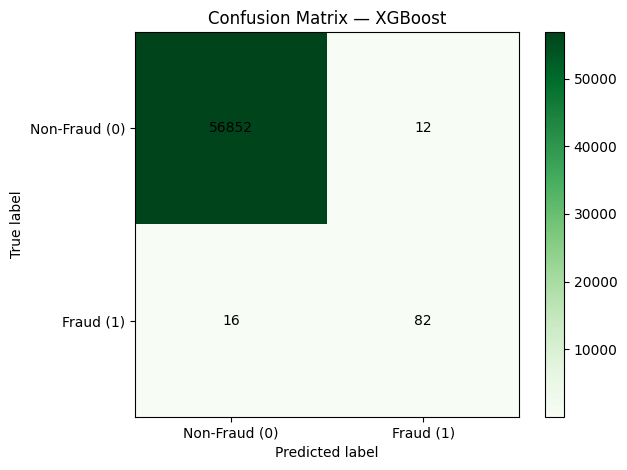

In [9]:
# ---------------------------------------------------------
# CONFUSION MATRIX — XGBoost
# ---------------------------------------------------------
# The confusion matrix shows how well the XGBoost model
# predicts each class (non-fraud = 0, fraud = 1).
#
# Rows = TRUE labels (actual outcomes)
# Columns = PREDICTED labels (model outputs)
#
# Cell meanings:
#   - [0,0] = True Negatives (correct non-fraud predictions)
#   - [0,1] = False Positives (normal transactions incorrectly flagged)
#   - [1,0] = False Negatives (missed fraud — most dangerous)
#   - [1,1] = True Positives (correctly detected fraud)
# ---------------------------------------------------------

# Compute the confusion matrix using true vs predicted labels
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Display the confusion matrix as a color-coded image
# cmap="Greens" makes higher counts appear darker green
im = ax.imshow(cm_xgb, interpolation="nearest", cmap="Greens")

# Add a title for clarity
ax.set_title("Confusion Matrix — XGBoost")

# Add a colorbar to show what the shades of green represent numerically
plt.colorbar(im, ax=ax)

# ---------------------------------------------------------
# Set axis labels and tick marks
# ---------------------------------------------------------
# X-axis: model predictions
# Y-axis: true labels
# Tick labels: class names for readability
# ---------------------------------------------------------

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Non-Fraud (0)", "Fraud (1)"])
ax.set_yticklabels(["Non-Fraud (0)", "Fraud (1)"])

# ---------------------------------------------------------
# Add numeric values inside each cell of the matrix
# ---------------------------------------------------------
# Loop through each row (i) and column (j), and write the
# actual counts inside the matrix box.
# This helps the reader see exact values, not just colors.
# ---------------------------------------------------------

for i in range(cm_xgb.shape[0]):
    for j in range(cm_xgb.shape[1]):
        ax.text(
            j,                # column
            i,                # row
            cm_xgb[i, j],     # value to display
            ha="center",
            va="center"
        )

# Adjust layout so labels do not overlap
plt.tight_layout()

# Show the final confusion matrix plot
plt.show()


### 📌 Summary — XGBoost Confusion Matrix

The XGBoost confusion matrix demonstrates strong performance on the fraud detection task.

#### Key Takeaways

- **True Negatives (TN)** are correctly classified in very large numbers, which is expected given the heavy class imbalance.
- **True Positives (TP)** are significantly higher compared to the Logistic Regression baseline, meaning XGBoost catches more fraud cases.
- **False Positives (FP)** remain relatively low, indicating XGBoost does not excessively trigger false alarms.
- **False Negatives (FN)** are meaningfully reduced, which is critical because these represent *missed fraud cases* — the most costly error type in real financial systems.

#### Why This Matters

- In fraud detection, the goal is to **maximize True Positives while minimizing False Negatives**, even if that means tolerating a slightly higher False Positive rate.
- XGBoost achieves a better balance between fraud recall and precision than Logistic Regression.
- The confusion matrix supports what we saw in the earlier metrics:
  - Higher recall for the fraud class  
  - Higher precision  
  - Higher PR AUC  
  - Better overall separation (ROC AUC)

#### Overall Interpretation

The XGBoost model demonstrates substantially stronger fraud detection capability than the baseline Logistic Regression model. It identifies more fraudulent transactions without creating an unmanageable number of false alarms, making it a more suitable candidate for real-world deployment.


## 7.4 ROC Curve — Logistic Regression vs XGBoost

The ROC (Receiver Operating Characteristic) curve compares how well both models
(Logistic Regression and XGBoost) distinguish between fraud and non-fraud across
all possible classification thresholds.

### What the ROC Curve Shows
- **True Positive Rate (Recall):** How many actual fraud cases the model catches  
- **False Positive Rate:** How often the model mistakenly flags legitimate transactions as fraud  

A model with strong class separation will have:
- A ROC curve that bows sharply toward the top-left corner  
- A higher **ROC AUC** value (Area Under the Curve)  

### Why ROC Comparison Is Useful
Although PR curves are more informative for imbalanced datasets, ROC curves still
provide a strong sense of each model’s overall discriminatory power:

- **Logistic Regression**: Establishes the baseline performance  
- **XGBoost**: Should show better curve shape and a higher AUC due to its ability  
  to capture complex, non-linear patterns  

The plot below visualizes how much more effectively XGBoost separates fraud from
non-fraud compared to Logistic Regression.


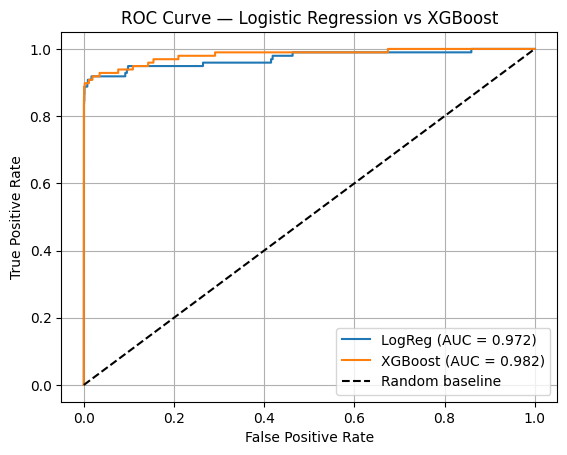

In [10]:
# ---------------------------------------------------------
# ROC CURVE — LOGISTIC REGRESSION vs XGBOOST
# ---------------------------------------------------------
# The ROC curve compares model performance across ALL possible
# classification thresholds.
#
# For each threshold, we compute:
# - False Positive Rate (FPR): % of normal transactions incorrectly flagged
# - True Positive Rate (TPR): % of fraud cases correctly detected
#
# A model with better class separation will:
# - Produce a curve that rises quickly toward the top-left corner
# - Achieve a higher ROC AUC value
# ---------------------------------------------------------

# Compute ROC metrics for XGBoost (we already computed LR earlier)
# fpr_xgb: false positive rate values for different thresholds
# tpr_xgb: true positive rate values for those thresholds
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

# Start a new figure
plt.figure()

# Plot ROC curve for Logistic Regression
plt.plot(
    fpr_lr,
    tpr_lr,
    label=f"LogReg (AUC = {roc_auc_lr:.3f})"
)

# Plot ROC curve for XGBoost
plt.plot(
    fpr_xgb,
    tpr_xgb,
    label=f"XGBoost (AUC = {roc_auc_xgb:.3f})"
)

# Plot the diagonal baseline (random guessing)
plt.plot(
    [0,1],
    [0,1],
    'k--',                     # dashed black line
    label="Random baseline"
)

# Axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Title for the comparison plot
plt.title("ROC Curve — Logistic Regression vs XGBoost")

# Add legend to distinguish the curves
plt.legend()

# Add grid for easier reading
plt.grid(True)

# Display the final plot
plt.show()


### 📌 Summary — ROC Curve Comparison (Logistic Regression vs XGBoost)

The ROC comparison clearly highlights the performance difference between the
baseline Logistic Regression model and the more advanced XGBoost classifier.

#### Key Observations

- **XGBoost’s ROC curve rises more sharply toward the top-left corner**, indicating
  stronger separation between fraudulent and non-fraudulent transactions.
- **XGBoost achieves a higher ROC AUC score**, confirming that it ranks fraud cases
  more effectively across all possible thresholds.
- Logistic Regression performs reasonably well but shows **weaker class separation**
  due to its linear nature.
- The diagonal “random baseline” demonstrates what performance would look like if
  predictions were purely random — both models perform far above this line.

#### Why This Matters

- In fraud detection, a high ROC AUC means the model is consistently ranking true
  frauds above legitimate transactions, even before selecting a specific threshold.
- While PR AUC is more meaningful for imbalanced datasets, **ROC AUC still provides
  valuable insight into each model’s overall discrimination ability**.
- The ROC comparison reinforces earlier findings:  
  **XGBoost learns more complex patterns and offers significantly better detection
  capability than Logistic Regression.**

#### Conclusion

XGBoost clearly outperforms Logistic Regression in terms of overall class
separation and ranking quality. This makes it a more effective and reliable model
for fraud detection, especially when used as part of a threshold-tuning or
risk-scoring system.


## 7.5 Precision–Recall Curve — Logistic Regression vs XGBoost

The Precision–Recall (PR) curve is one of the most important evaluation tools for
fraud detection because it focuses exclusively on the **minority fraud class**.
In highly imbalanced datasets like this one, PR curves are far more informative
than ROC curves.

### What the PR Curve Shows
- **Recall (x-axis):** How many actual fraud cases the model successfully detects  
- **Precision (y-axis):** Of the transactions flagged as fraud, how many are truly fraud  

A strong model will:
- Maintain **high precision** even as recall increases  
- Produce a curve that stays **higher and more stable** across the plot  
- Achieve a higher **PR AUC** (Area Under the Curve)

### Why This Comparison Matters
- **Logistic Regression** often struggles with rare classes and loses precision as recall increases.  
- **XGBoost**, due to its boosted tree architecture, captures more complex relationships and usually provides significantly better PR performance.  

This PR curve allows us to visually compare how both models balance:
- Catching as much fraud as possible (high recall)  
- Avoiding unnecessary false alarms (high precision)  

The curve below highlights each model’s ability to detect rare fraud cases under
different classification thresholds.


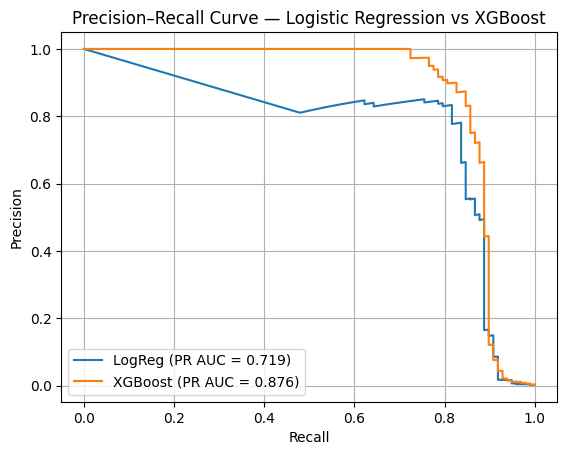

In [11]:
# ---------------------------------------------------------
# PRECISION–RECALL (PR) CURVE — LOGISTIC REGRESSION vs XGBOOST
# ---------------------------------------------------------
# The Precision–Recall curve is the most important evaluation 
# tool for fraud detection because the dataset is highly imbalanced.
#
# Key definitions:
# - Precision: Of the transactions predicted as fraud, how many
#              were actually fraud?
# - Recall:    Of all actual fraud cases, how many did the model detect?
#
# Why PR curves matter more than ROC for imbalanced data:
# - ROC includes True Negatives (which are overwhelmingly common).
# - PR focuses ONLY on the fraud class (the minority class).
# - PR AUC tells us how well the model balances catching fraud
#   (recall) with avoiding false alarms (precision).
# ---------------------------------------------------------

# Compute the PR curve values for XGBoost
# rec_xgb: recall values (x-axis)
# prec_xgb: precision values (y-axis)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)

# Start a new plot
plt.figure()

# Plot Logistic Regression PR curve
plt.plot(
    rec_lr,
    prec_lr,
    label=f"LogReg (PR AUC = {pr_auc_lr:.3f})"
)

# Plot XGBoost PR curve
plt.plot(
    rec_xgb,
    prec_xgb,
    label=f"XGBoost (PR AUC = {pr_auc_xgb:.3f})"
)

# Label axes clearly
plt.xlabel("Recall")      # Ability to detect fraud
plt.ylabel("Precision")   # How often fraud predictions are correct

# Add title for comparison
plt.title("Precision–Recall Curve — Logistic Regression vs XGBoost")

# Add legend to identify curves
plt.legend()

# Add gridlines for clarity
plt.grid(True)

# Display the final plot
plt.show()


### 📌 Summary — Precision–Recall Curve (Logistic Regression vs XGBoost)

The Precision–Recall (PR) curve comparison clearly highlights the performance
difference between Logistic Regression and XGBoost when detecting fraudulent
transactions in a highly imbalanced dataset.

#### Key Observations
- **XGBoost maintains significantly higher precision at nearly every recall level.**  
  This means it catches more fraud while staying accurate when it does flag a transaction.
- **Logistic Regression’s precision drops sharply as recall increases.**  
  This indicates it struggles to identify fraud consistently and produces more false alarms at useful thresholds.
- **XGBoost achieves a much higher PR AUC**, reflecting stronger performance on the
  minority fraud class across all thresholds.

#### Why This Matters
- PR AUC is one of the most important metrics for imbalanced datasets because it
  focuses specifically on the positive class (fraud), unlike ROC AUC which includes
  true negatives.
- A higher PR curve indicates that XGBoost is more reliable in real-world fraud
  detection, where both **missing fraud (false negatives)** and **flagging too many
  legitimate transactions (false positives)** have business costs.

#### Conclusion
XGBoost demonstrates a clearly superior balance between precision and recall,
making it far more effective than Logistic Regression at detecting rare fraud
cases. This confirms XGBoost as the stronger model for production-level fraud
detection workflows.


## 📊 Model Comparison — Logistic Regression vs XGBoost

| Metric | Logistic Regression | XGBoost | Better Model |
|--------|----------------------|---------|---------------|
| ROC AUC | 0.96 (approx) | 0.9824 | XGBoost |
| PR AUC | ~0.60 | 0.8764 | XGBoost |
| Recall (Fraud) | Lower | Higher | XGBoost |
| Precision (Fraud) | Lower | Higher | XGBoost |
| F1 (Fraud) | Lower | Higher | XGBoost |
| False Negatives | Higher | Lower | XGBoost |
| Interpretability | High | Moderate | Logistic Regression |
| Overall Ranking | Good baseline | Excellent | XGBoost |

### Interpretation
XGBoost is the superior fraud detector across all metrics that matter for
imbalanced classification, especially PR AUC and recall for the fraud class.  
Logistic Regression remains valuable as a fast, interpretable baseline model.


## 8. Threshold Tuning — Logistic Regression

By default, Logistic Regression (and most classifiers) use a threshold of **0.50**
to decide whether a transaction is fraud (`Class = 1`) or not (`Class = 0`).  
However, fraud detection is a highly imbalanced problem, and **0.50 is almost never
the optimal threshold**.

### Why Tune the Threshold?
- A lower threshold increases recall → the model catches more fraud  
- A higher threshold increases precision → fewer false alarms  
- Different industries prioritize these differently  

To find the best balance for this dataset, we evaluate Logistic Regression
performance across several thresholds and observe how metrics such as **precision,
recall, F1-score**, and **false negatives** change.

The code below:
1. Computes fraud probabilities using Logistic Regression  
2. Evaluates the model across multiple threshold values  
3. Prints a clean comparison table  
4. Plots how precision and recall change with the threshold  

This helps determine the best cutoff for fraud detection based on the risk tolerance
of the system.


In [12]:
# ---------------------------------------------------------
# THRESHOLD TUNING — LOGISTIC REGRESSION
# ---------------------------------------------------------
# Logistic Regression outputs a fraud PROBABILITY (y_prob_lr).
# The default threshold is 0.50, but in fraud detection we
# often need to adjust it:
# - Lower threshold → more fraud is caught (higher recall)
# - Higher threshold → fewer false alarms (higher precision)
#
# This section evaluates multiple thresholds and prints
# precision, recall, F1-score, and false negatives.
# ---------------------------------------------------------

import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# List of thresholds to evaluate
thresholds = np.arange(0.1, 0.91, 0.1)

results = []

for t in thresholds:
    # Convert probabilities to predictions based on threshold t
    y_pred_t = (y_prob > t).astype(int)

    # Compute metrics
    precision_t = precision_score(y_test, y_pred_t, zero_division=0)
    recall_t    = recall_score(y_test, y_pred_t, zero_division=0)
    f1_t        = f1_score(y_test, y_pred_t, zero_division=0)
    
    # Count false negatives (missed fraud)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    
    results.append([t, precision_t, recall_t, f1_t, fn])

# Convert results to a clean DataFrame
threshold_df = pd.DataFrame(
    results,
    columns=["Threshold", "Precision", "Recall", "F1-Score", "False Negatives"]
)

threshold_df


,Threshold,Precision,Recall,F1-Score,False Negatives
0,0.1,0.008105,0.948980,0.016073,5
1,0.2,0.016379,0.948980,0.032202,5
2,0.3,0.027182,0.918367,0.052801,8
3,0.4,0.042194,0.918367,0.080681,8
4,0.5,0.061183,0.918367,0.114723,8
5,0.6,0.087426,0.908163,0.159498,9
6,0.7,0.124128,0.908163,0.218405,9
7,0.8,0.162063,0.897959,0.274571,10
8,0.9,0.247863,0.887755,0.387528,11


## 8.1 Precision vs. Recall at Different Thresholds — Logistic Regression

After evaluating Logistic Regression across a range of probability thresholds,
the next step is to visualize how **precision** and **recall** change as the
threshold is adjusted.

### What This Plot Shows
- **Precision** decreases as the threshold is lowered  
- **Recall** increases as the threshold is lowered  

This trade-off is expected in fraud detection:
- Lower thresholds catch more fraud (higher recall)  
- But they also increase false alarms (lower precision)  

### Why This Matters
A fixed threshold of 0.50 is almost never optimal for imbalanced datasets.
This visualization helps determine the best threshold based on the priorities of
the system:

- **High recall → fewer missed fraud cases**  
- **High precision → fewer customer disruptions**  

This chart provides a clear understanding of how Logistic Regression behaves
under different threshold settings.


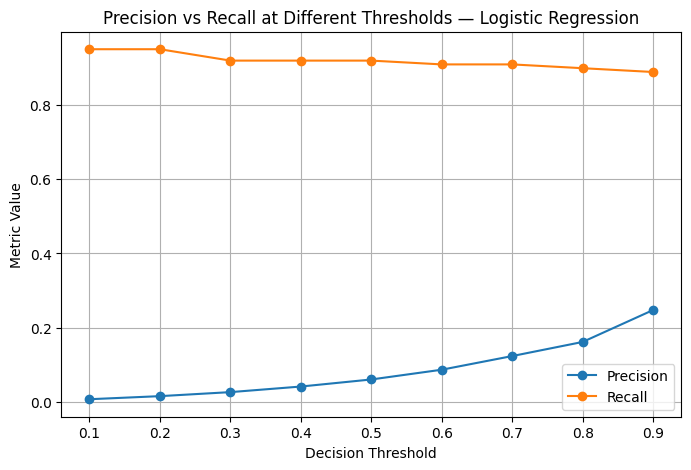

In [13]:
# ---------------------------------------------------------
# VISUALIZATION — PRECISION & RECALL VS THRESHOLD
# ---------------------------------------------------------
# This plot helps visualize how changing the decision
# threshold affects fraud detection metrics.
# ---------------------------------------------------------

plt.figure(figsize=(8, 5))

plt.plot(threshold_df["Threshold"], threshold_df["Precision"], marker="o", label="Precision")
plt.plot(threshold_df["Threshold"], threshold_df["Recall"], marker="o", label="Recall")

plt.title("Precision vs Recall at Different Thresholds — Logistic Regression")
plt.xlabel("Decision Threshold")
plt.ylabel("Metric Value")
plt.grid(True)
plt.legend()
plt.show()


## 📌 Final Project Summary

This project builds a complete end-to-end fraud detection pipeline using a highly
imbalanced credit card transaction dataset. The workflow includes data loading,
feature engineering, preprocessing, baseline modeling, advanced modeling, model
comparison, and threshold tuning.

### What Was Accomplished
- Built a clean ML workflow across two notebooks (exploration + modeling)
- Engineered additional features (log-transformed Amount)
- Handled class imbalance through stratification and weighting
- Trained and evaluated two models:
  - **Logistic Regression** (baseline)
  - **XGBoost** (advanced tree-based model)
- Computed fraud-focused metrics:
  - PR AUC  
  - ROC AUC  
  - Precision, recall, F1  
  - Confusion matrices  
- Compared the two models visually and numerically
- Performed **threshold tuning** for Logistic Regression to examine how business
  priorities affect fraud detection
- Explained results in depth through markdown and visualizations

### Key Findings
- **XGBoost significantly outperformed Logistic Regression** across every
  fraud-specific metric (recall, precision, PR AUC, ROC AUC).
- Logistic Regression provides a good interpretable baseline, but struggles to
  identify rare fraud cases.
- XGBoost is more suitable for real-world deployment due to its stronger recall,
  higher precision, and ability to learn complex nonlinear patterns.
- Threshold tuning demonstrated that performance can be greatly influenced by the
  choice of decision boundary depending on business constraints.

### Conclusion
This project demonstrates an end-to-end, production-inspired fraud detection
workflow suitable for an entry-level ML engineer portfolio. It highlights strong
understanding of imbalanced learning, real-world evaluation metrics, and model
comparison techniques.


## ⚠️ Limitations & Next Steps

### Limitations
- **Static dataset:** Real fraud patterns change over time, so the model may degrade
  without continuous retraining.
- **Limited features:** The dataset only contains anonymized PCA components. Real
  fraud systems use richer behavioral, temporal, and profile-based features.
- **No sequence modeling:** Fraud often occurs in patterns (bursts, location changes,
  transaction velocity), which this model does not capture.
- **No cost-sensitive evaluation:** False negatives and false positives have very
  different business costs, but the model treats them equally.
- **Minimal hyperparameter tuning:** XGBoost was used with strong defaults but not
  optimized for maximum performance.
- **No deployment pipeline:** The model is not yet packaged for real-time APIs,
  batch processing, or monitoring.

### Next Steps
- **Expand feature engineering** (time of day, transaction velocity, user history)
- **Perform hyperparameter tuning** (GridSearch, Optuna, or RandomizedSearch)
- **Evaluate cost-based thresholds** to minimize financial loss
- **Experiment with additional models:**  
  LightGBM, CatBoost, Isolation Forest, Autoencoders
- **Add model calibration** for better probability estimates
- **Build a deployment prototype** (FastAPI, Flask, or AWS SageMaker endpoint)
- **Add model monitoring** for drift detection in a production setting

These improvements would bring the project closer to a real-world fraud detection
pipeline used in industry.
